In [1]:
#Instalacaicón de paquetes
!pip install spacepy
!pip install cdflib
!pip install matplotlib

In [2]:
#Instalación de librerías
import cdflib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import json
#dmsp-f16_ssm_magnetometer_20130601_v1.0.4.cdf
![Binder](https://mybinder.org/badge_logo.svg)(https://mybinder.org/v2/gh/lkilcommons/OvationPyme/HEAD?labpath=notebooks%2FInteractiveWithHemisphericPower.ipynb) #Binder para ejecutar el código en línea en un servidor de Jupyter Notebook en la nube de forma gratuita sin necesidad de instalar nada en tu computadora local y sin necesidad de registrarte en ningún sitio web ni de proporcionar ningún tipo de información personal o de pago en línea para ejecutar el código en línea en un servidor de Jupyter Notebook en la nube de forma gratuita sin necesidad de instalar nada en tu computadora local y sin necesidad de registrarte en ningún sitio web ni de proporcionar ningún tipo de información personal o de pago en línea

"[Binder]" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Procesando archivo: dmsp-f16_ssjs_precipitating-electrons-ions_20141231000000_20141231235959_cdaweb.cdf
Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20141231000000_20141231235959_cdaweb.cdf


C:\Users\benja\AppData\Local\Temp\ipykernel_24968\2077625644.py:41: RuntimeWarning: divide by zero encountered in log10
  return np.log10(array)


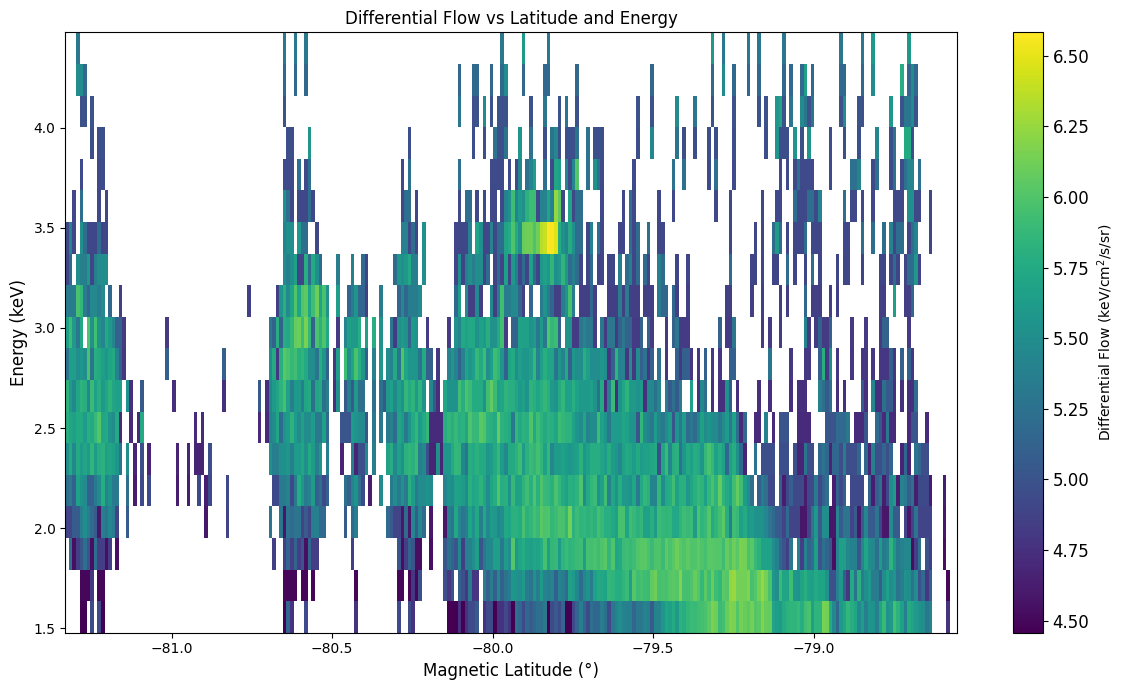

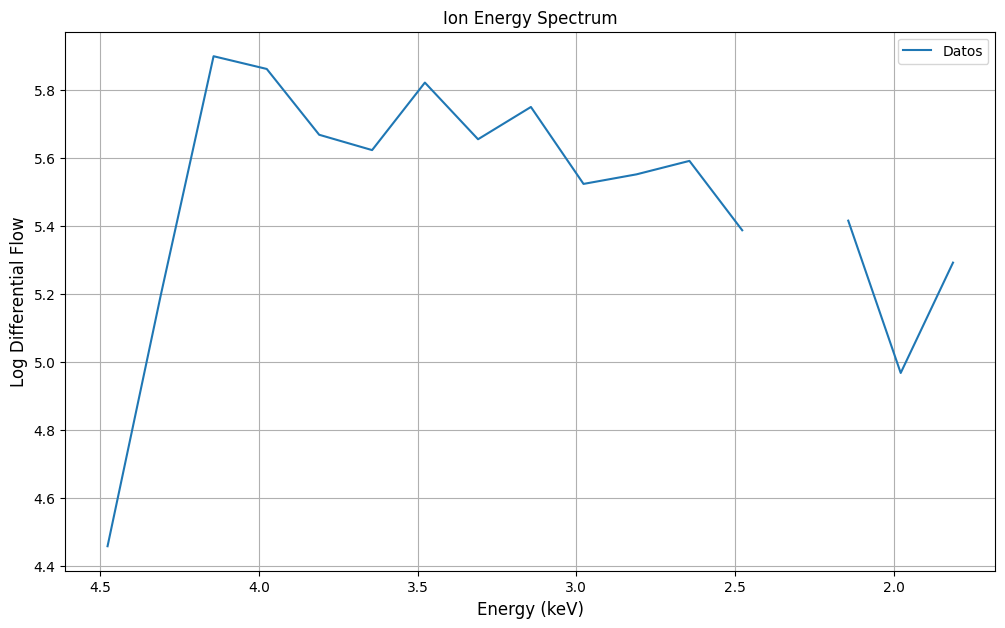

b2i se encuentra en la latitud magnética -80.976° y en el tiempo 2014-12-31T22:03:34.000000000



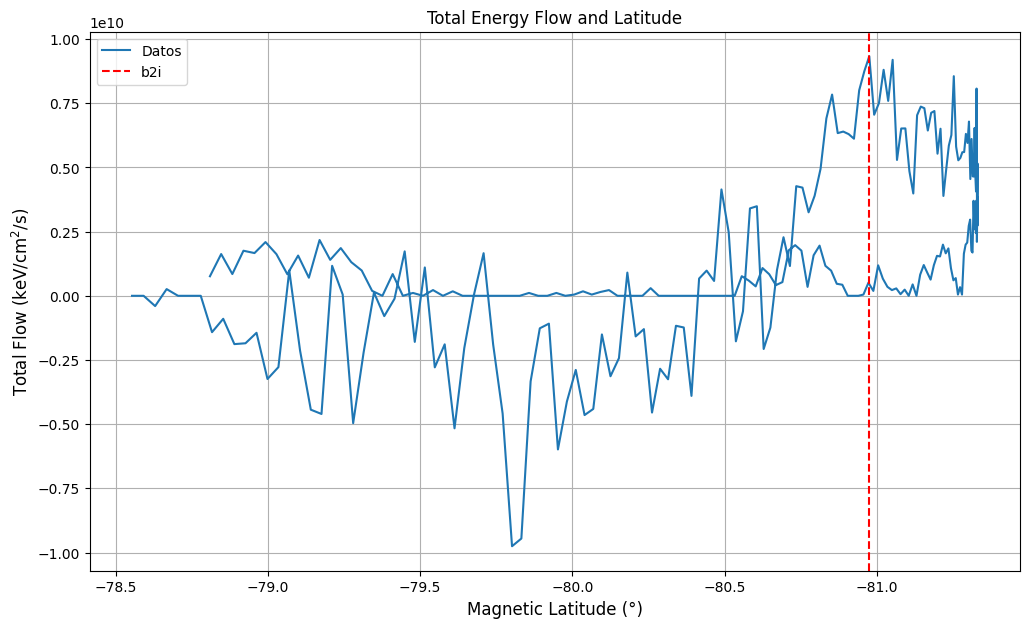

Procesando archivo: dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf
Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf


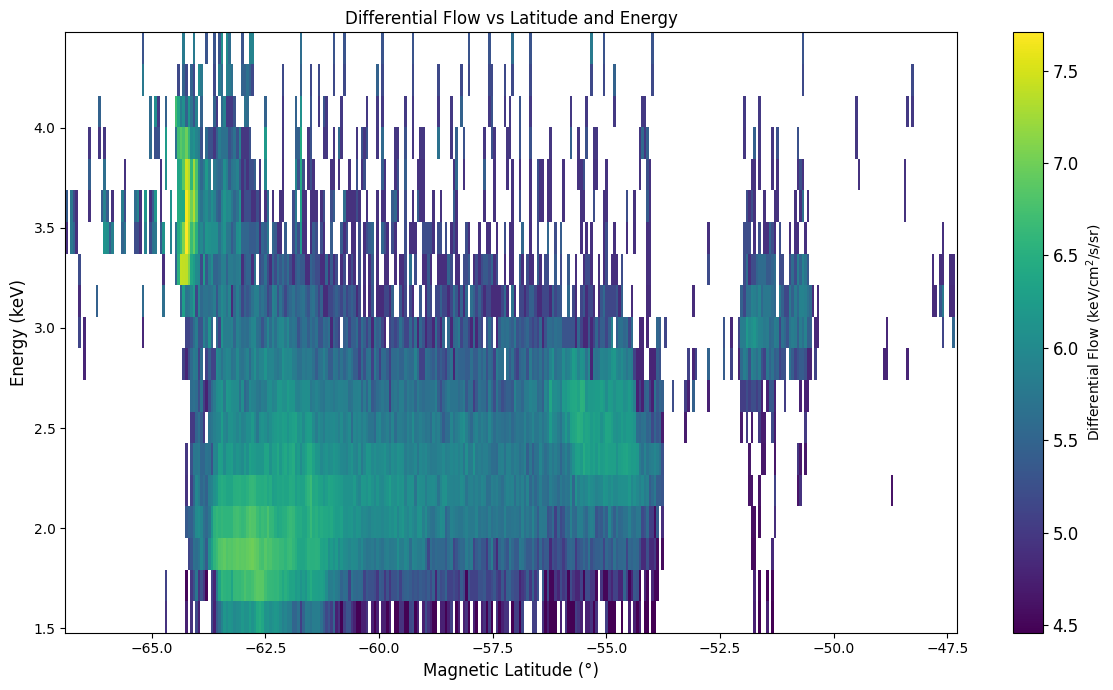

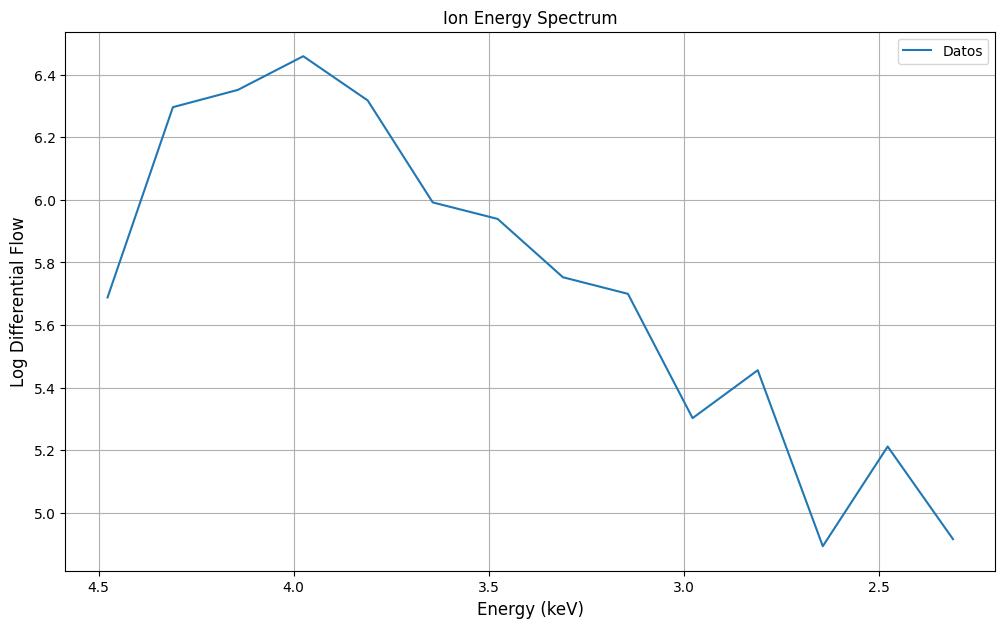

b2i se encuentra en la latitud magnética -51.457° y en el tiempo 2013-05-31T22:02:53.000000000



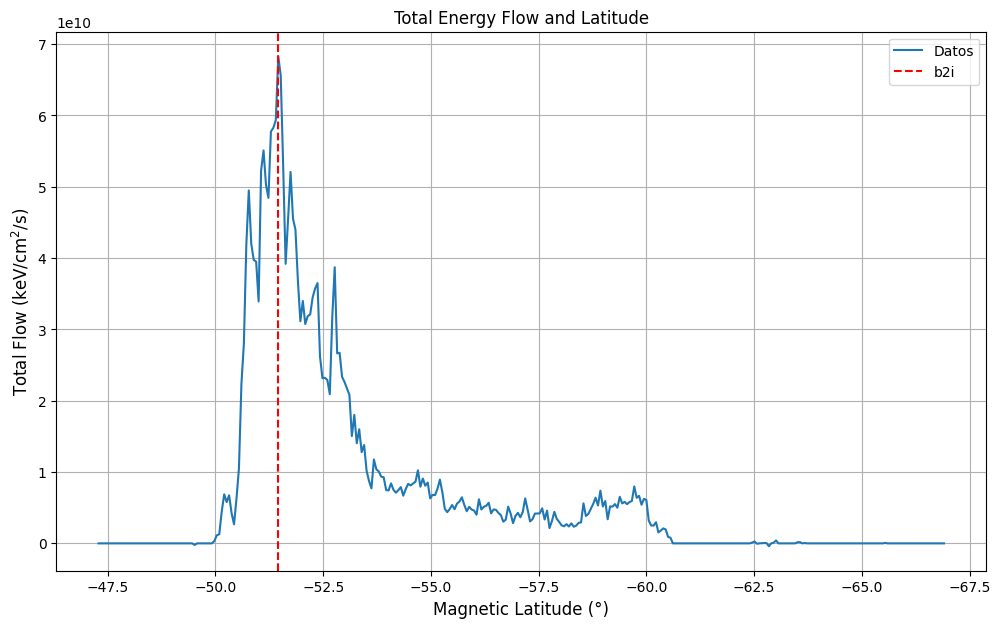

In [3]:
def cargar_datos(ruta_archivo):
    """
    Carga las variables necesarias desde un archivo CDF y aplica filtros de rango basados en VALIDMIN y VALIDMAX.

    Args:
        ruta_archivo (str): Ruta del archivo CDF.

    Returns:
        dict: Diccionario con las variables cargadas y filtradas.
    """
    try:
        cdf = cdflib.CDF(ruta_archivo)
        print(f"Archivo cargado: {ruta_archivo}")

        datos = {}
        for variable in cdf.cdf_info().zVariables:
            attrs = cdf.varattsget(variable)
            if 'VALIDMIN' in attrs and 'VALIDMAX' in attrs:
                valid_min = attrs['VALIDMIN']
                valid_max = attrs['VALIDMAX']
                raw_data = cdf.varget(variable)
                datos[variable] = np.where((raw_data >= valid_min) & (raw_data <= valid_max), raw_data, np.nan)
            else:
                datos[variable] = cdf.varget(variable)

        return datos
    except KeyError as e:
        print(f"Error: Variable no encontrada: {e}")
        return None

def logaritmizar_ajustado(array):
    """
    Aplica logaritmo base 10 sumando una constante pequeña a todos los datos.

    Args:
        array (array): Datos a logaritmizar.

    Returns:
        array: Datos logaritmizados.
    """
    return np.log10(array)

def calculo_delta(energias):
    """
    Calcula el ancho de las bandas energéticas.

    Args:
        energias (array): Energías.

    Returns:
        array: Ancho de las bandas energéticas.
    """
    delta = [(e2 - e1) / 2 for e1, e2 in zip(energias[1:], energias[:-1])]
    Left = energias[1] - energias[0]  # Extremo izquierdo.
    Right = energias[-1] - energias[-2]  # Extremo derecho.
    delta.insert(0, Left)
    delta.append(Right)
    return delta

def calculo_energia_total(flujos, delta, bandas):
    """
    Calcula el flujo total de energía para cada punto.

    Args:
        flujos (array): Flujo de energía diferencial.
        delta (array): Ancho de las bandas energéticas.
        bandas (int): Número de bandas energéticas consideradas.

    Returns:
        array: Flujo total de energía.
    """
    delta_recortado = np.array(delta[:bandas])  # Selecciona solo las primeras bandas
    return [sum(flujo[:bandas] * delta_recortado) for flujo in flujos]

def graficocolor(latitudes, energias, flujo, titulo, xlabel, ylabel, labelcolorbar):
    """
    Genera un gráfico de color.

    Args:
        latitudes (array): Latitudes magnéticas.
        energias (array): Energías.
        flujo (array): Flujo de energía.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
        labelcolorbar (str): Etiqueta de la barra de color.
    """
    lat_edges = np.linspace(latitudes.min(), latitudes.max(), len(latitudes) + 1)
    energy_edges = np.linspace(energias.min(), energias.max(), len(energias) + 1)
    plt.figure(figsize=(12, 7))
    plt.pcolormesh(lat_edges, energy_edges, flujo, cmap="viridis", shading='auto')
    cbar = plt.colorbar(label=labelcolorbar)
    cbar.ax.tick_params(labelsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

def graficar(x, y, titulo, xlabel, ylabel,b2i=False):
    """
    Genera un gráfico de línea.

    Args:
        x (array): Datos del eje x.
        y (array): Datos del eje y.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
    """
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, label='Datos')
    plt.title(titulo)
    if b2i:
        plt.axvline(b2i, color='r', linestyle='--', label='b2i')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()

def calcular_b2i(latitudes, flujo_total):
    """
    Identifica la latitud b2i como el máximo flujo total.

    Args:
        latitudes (array): Latitudes magnéticas.
        flujo_total (array): Flujo total de energía.

    Returns:
        float: Latitud b2i.
        int: Índice de la latitud b2i.
    """
    max_indice = np.argmax(flujo_total)
    b2i = latitudes[max_indice]
    return b2i, max_indice

def flujo_energetico_dms(filename, rango, espectro, bandas):
    """
    Proceso principal para calcular y graficar el flujo energético desde un archivo CDF.

    Args:
        filename (str): Ruta del archivo CDF.
        rango (tuple): Rango de índices a analizar (inicio, fin).
        espectro (int): Índice del espectro buscado.
        bandas (int): Número de bandas energéticas consideradas.
    """
    # Carga de datos filtrados
    datos = cargar_datos(filename)
    if datos is None:
        print("Error en la carga de datos. Revisa el archivo.")
        return

    tiempo = cdflib.cdfepoch.to_datetime(datos['Epoch'])
    latitudes = datos['SC_GEOCENTRIC_LAT']
    energias = datos['CHANNEL_ENERGIES']
    flujo_diferencial = datos['ION_DIFF_ENERGY_FLUX']

    N1, N2 = rango
    NS = espectro

    # Logaritmo de datos
    log_flujo_diferencial = logaritmizar_ajustado(flujo_diferencial)
    log_energias = logaritmizar_ajustado(energias)
    traspuesta_log_flujo = np.transpose(log_flujo_diferencial[N1:N2])

    # Gráfico de color: Flujo Diferencial
    graficocolor(
        latitudes[N1:N2], log_energias, traspuesta_log_flujo,
        "Differential Flow vs Latitude and Energy", "Magnetic Latitude (°)",
        "Energy (keV)", "Differential Flow (keV/cm$^2$/s/sr)"
    )

    # Gráfico de espectro: Energía de Iones
    graficar(
        log_energias, log_flujo_diferencial[NS],
        "Ion Energy Spectrum", "Energy (keV)", "Log Differential Flow"
    )

    # Cálculo de flujo total de energía
    delta = calculo_delta(energias)
    total_flujo = calculo_energia_total(flujo_diferencial[N1:N2], delta, bandas)

    # Calcular y mostrar b2i
    b2i, max_indice = calcular_b2i(latitudes[N1:N2], total_flujo)
    print(f"b2i se encuentra en la latitud magnética {b2i:.3f}° y en el tiempo {tiempo[N1:N2][max_indice]}", end="\n\n")

    # Gráfico de Flujo Total
    graficar(
        latitudes[N1:N2], total_flujo,
        "Total Energy Flow and Latitude", "Magnetic Latitude (°)", "Total Flow (keV/cm$^2$/s)", b2i
    )
# Parámetros y archivos en un archivo JSON
with open('parametros.json', 'r') as file:
    data = json.load(file)

# Iterar sobre la lista de archivos y aplicar la función principal
for archivo in data['archivos']:
    print(f"Procesando archivo: {archivo['archivo']}")
    flujo_energetico_dms(
        archivo["archivo"],
        archivo["rango_datos"],
        archivo["espectro_datos"],
        archivo["bandas_energeticas"]
    )

Procesando archivo: dmsp-f16_ssjs_precipitating-electrons-ions_20141231000000_20141231235959_cdaweb.cdf
Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20141231000000_20141231235959_cdaweb.cdf
Partícula seleccionada: electrons


C:\Users\benja\AppData\Local\Temp\ipykernel_24968\2222466486.py:41: RuntimeWarning: divide by zero encountered in log10
  return np.log10(array)


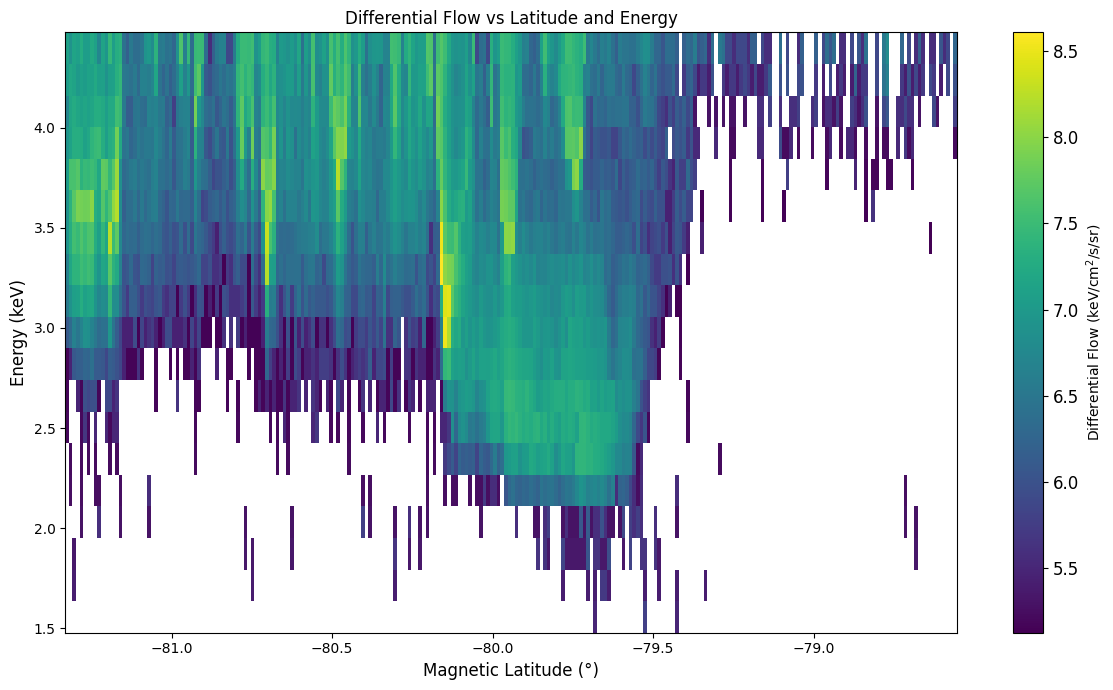

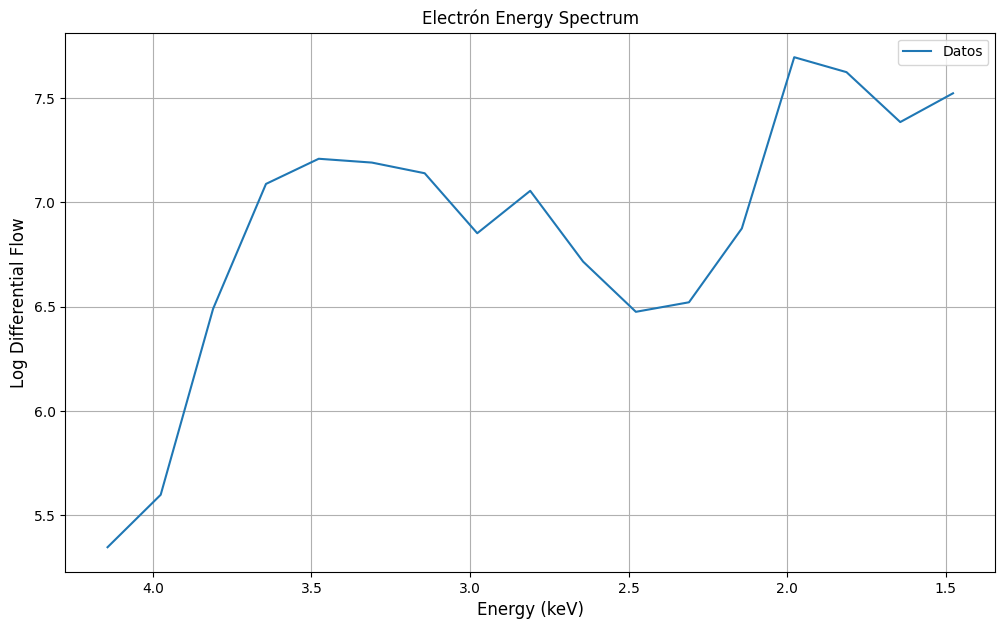

borde se encuentra en la latitud magnética -81.228° y en el tiempo 2014-12-31T22:03:14.000000000



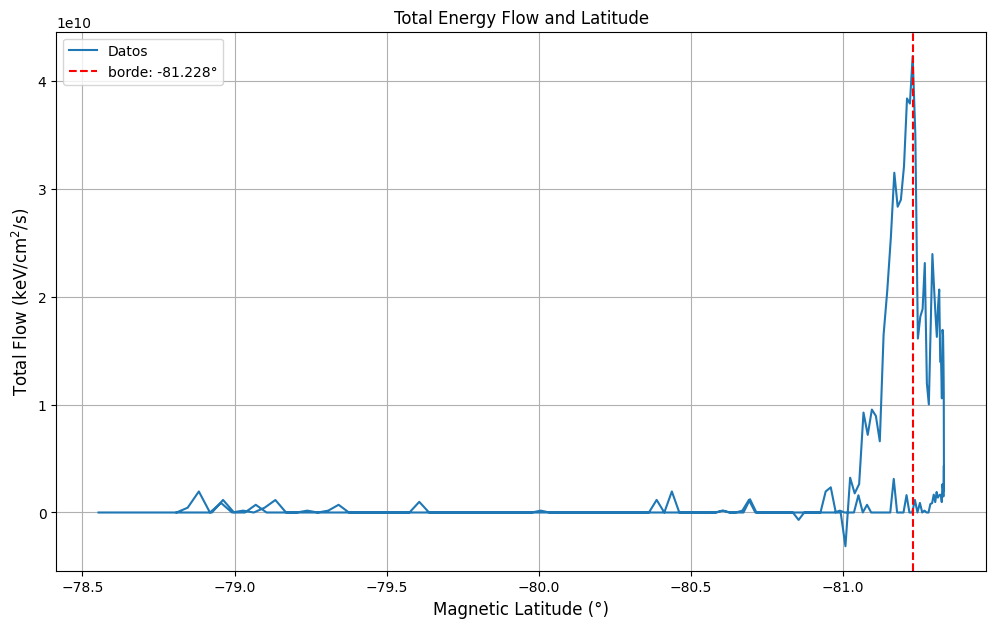

Procesando archivo: dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf
Archivo cargado: dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf
Partícula seleccionada: ions


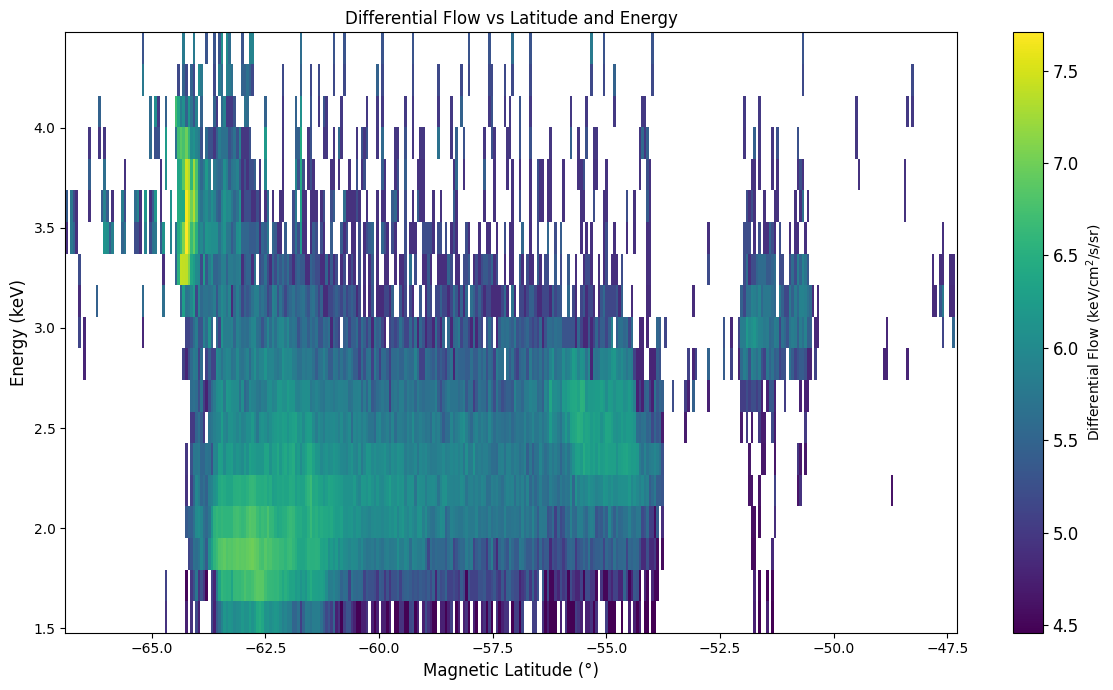

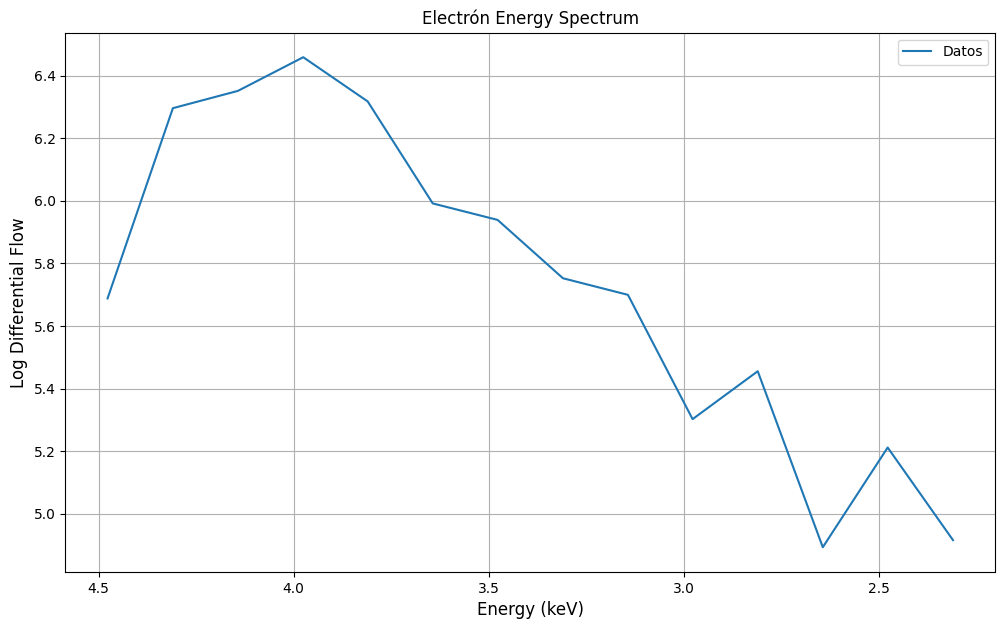

borde se encuentra en la latitud magnética -51.457° y en el tiempo 2013-05-31T22:02:53.000000000



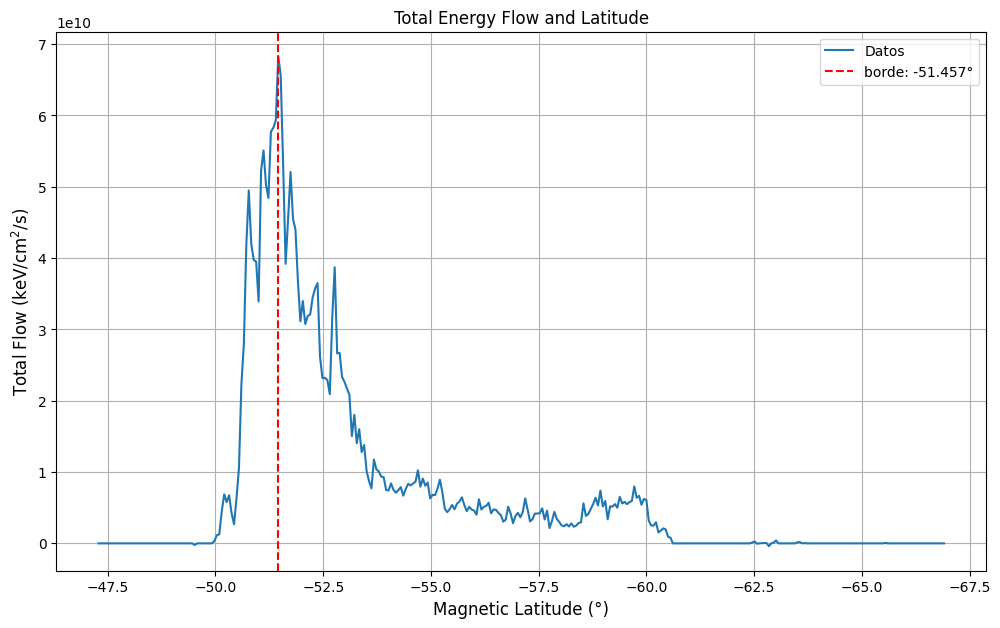

In [4]:
def cargar_datos(ruta_archivo):
    """
    Carga las variables necesarias desde un archivo CDF y aplica filtros de rango basados en VALIDMIN y VALIDMAX.

    Args:
        ruta_archivo (str): Ruta del archivo CDF.

    Returns:
        dict: Diccionario con las variables cargadas y filtradas.
    """
    try:
        cdf = cdflib.CDF(ruta_archivo)
        print(f"Archivo cargado: {ruta_archivo}")

        datos = {}
        for variable in cdf.cdf_info().zVariables:
            attrs = cdf.varattsget(variable)
            if 'VALIDMIN' in attrs and 'VALIDMAX' in attrs:
                valid_min = attrs['VALIDMIN']
                valid_max = attrs['VALIDMAX']
                raw_data = cdf.varget(variable)
                datos[variable] = np.where((raw_data >= valid_min) & (raw_data <= valid_max), raw_data, np.nan)
            else:
                datos[variable] = cdf.varget(variable)

        return datos
    except KeyError as e:
        print(f"Error: Variable no encontrada: {e}")
        return None

def logaritmizar_ajustado(array):
    """
    Aplica logaritmo base 10 sumando una constante pequeña a todos los datos.

    Args:
        array (array): Datos a logaritmizar.

    Returns:
        array: Datos logaritmizados.
    """
    return np.log10(array)

def calculo_delta(energias):
    """
    Calcula el ancho de las bandas energéticas.

    Args:
        energias (array): Energías.

    Returns:
        array: Ancho de las bandas energéticas.
    """
    delta = [(e2 - e1) / 2 for e1, e2 in zip(energias[1:], energias[:-1])]
    Left = energias[1] - energias[0]  # Extremo izquierdo.
    Right = energias[-1] - energias[-2]  # Extremo derecho.
    delta.insert(0, Left)
    delta.append(Right)
    return delta

def calculo_energia_total(flujos, delta, bandas):
    """
    Calcula el flujo total de energía para cada punto.

    Args:
        flujos (array): Flujo de energía diferencial.
        delta (array): Ancho de las bandas energéticas.
        bandas (int): Número de bandas energéticas consideradas.

    Returns:
        array: Flujo total de energía.
    """
    delta_recortado = np.array(delta[:bandas])  # Selecciona solo las primeras bandas
    return [sum(flujo[:bandas] * delta_recortado) for flujo in flujos]

def graficocolor(latitudes, energias, flujo, titulo, xlabel, ylabel, labelcolorbar):
    """
    Genera un gráfico de color.

    Args:
        latitudes (array): Latitudes magnéticas.
        energias (array): Energías.
        flujo (array): Flujo de energía.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
        labelcolorbar (str): Etiqueta de la barra de color.
    """
    lat_edges = np.linspace(latitudes.min(), latitudes.max(), len(latitudes) + 1) # Se calculan los bordes de las latitudes
    energy_edges = np.linspace(energias.min(), energias.max(), len(energias) + 1) # Se calculan los bordes de las energías
    plt.figure(figsize=(12, 7))
    plt.pcolormesh(lat_edges, energy_edges, flujo, cmap="viridis", shading='auto')
    cbar = plt.colorbar(label=labelcolorbar)
    cbar.ax.tick_params(labelsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

def graficar(x, y, titulo, xlabel, ylabel,borde=False):
    """
    Genera un gráfico de línea.

    Args:
        x (array): Datos del eje x.
        y (array): Datos del eje y.
        titulo (str): Título del gráfico.
        xlabel (str): Etiqueta del eje x.
        ylabel (str): Etiqueta del eje y.
    """
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, label='Datos')
    plt.title(titulo)
    if borde:
        plt.axvline(borde, color='r', linestyle='--', label=f'borde: {borde:.3f}°')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()

def calcular_borde(latitudes, flujo_total):
    """
    Identifica la latitud del borde como el máximo flujo total.

    Args:
        latitudes (array): Latitudes magnéticas.
        flujo_total (array): Flujo total de energía.

    Returns:
        float: Latitud borde.
        int: Índice de la latitud borde.
    """
    max_indice = np.argmax(flujo_total)
    borde = latitudes[max_indice]
    return borde, max_indice

def flujo_energetico_dms(filename, rango, espectro, bandas, seleccion_particula):
    """
    Proceso principal para calcular y graficar el flujo energético desde un archivo CDF.

    Args:
        filename (str): Ruta del archivo CDF.
        rango (tuple): Rango de índices a analizar (inicio, fin).
        espectro (int): Índice del espectro buscado.
        bandas (int): Número de bandas energéticas consideradas.
    """
    # Carga de datos filtrados
    datos = cargar_datos(filename)
    if datos is None:
        print("Error en la carga de datos. Revisa el archivo.")
        return

    tiempo = cdflib.cdfepoch.to_datetime(datos['Epoch'])
    latitudes = datos['SC_GEOCENTRIC_LAT']
    energias = datos['CHANNEL_ENERGIES']
    flujo_diferencial = datos['ELE_DIFF_ENERGY_FLUX' if seleccion_particula == "electrons" else 'ION_DIFF_ENERGY_FLUX']  # Selecciona el espectro
    print(f"Partícula seleccionada: {seleccion_particula}")



    N1, N2 = rango
    NS = espectro

    # Logaritmo de datos
    log_flujo_diferencial = logaritmizar_ajustado(flujo_diferencial)
    log_energias = logaritmizar_ajustado(energias)
    traspuesta_log_flujo = np.transpose(log_flujo_diferencial[N1:N2])

    # Gráfico de color: Flujo Diferencial
    graficocolor(
        latitudes[N1:N2], log_energias, traspuesta_log_flujo,
        "Differential Flow vs Latitude and Energy", "Magnetic Latitude (°)",
        "Energy (keV)", "Differential Flow (keV/cm$^2$/s/sr)"
    )

    # Gráfico de espectro: Energía de Iones
    graficar(
        log_energias, log_flujo_diferencial[NS],
        "Electrón Energy Spectrum", "Energy (keV)", "Log Differential Flow"
    )

    # Cálculo de flujo total de energía
    delta = calculo_delta(energias)
    total_flujo = calculo_energia_total(flujo_diferencial[N1:N2], delta, bandas)

    # Calcular y mostrar borde
    borde, max_indice = calcular_borde(latitudes[N1:N2], total_flujo)
    print(f"borde se encuentra en la latitud magnética {borde:.3f}° y en el tiempo {tiempo[N1:N2][max_indice]}", end="\n\n")

    # Gráfico de Flujo Total
    graficar(
        latitudes[N1:N2], total_flujo,
        "Total Energy Flow and Latitude", "Magnetic Latitude (°)", "Total Flow (keV/cm$^2$/s)", borde
    )
# Parámetros y archivos en un archivo JSON
with open('parametros.json', 'r') as file:
    data = json.load(file)



# Iterar sobre la lista de archivos y aplicar la función principal
for archivo in data['archivos']:
    print(f"Procesando archivo: {archivo['archivo']}")
    flujo_energetico_dms(
        archivo["archivo"],
        archivo["rango_datos"],
        archivo["espectro_datos"],
        archivo["bandas_energeticas"],
        archivo["seleccion_particula"],
    )

El límite b2e se encuentra en la latitud magnética: -59.07°


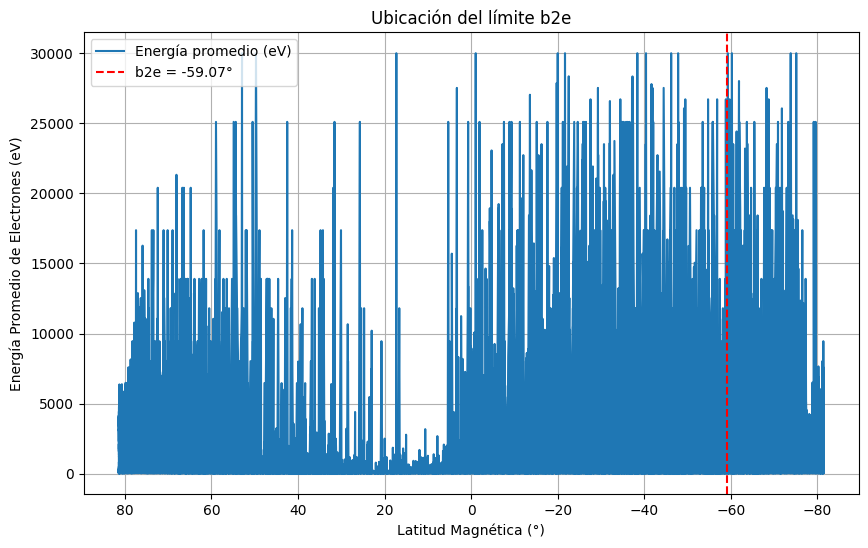

In [5]:
def calcular_b2e(latitudes, energias):
    """
    Identifica el límite b2e basado en el gradiente de la energía promedio de electrones.

    Args:
        latitudes (array): Latitudes magnéticas.
        energias (array): Energías promedio de electrones (eV).

    Returns:
        float: Latitud del límite b2e.
        int: Índice de la latitud b2e.
    """
    # Calcular el gradiente de la energía promedio (dEe/dX)
    gradiente = np.gradient(energias, latitudes)

    # Localizar el primer punto donde dEe/dX <= 0
    for i in range(len(gradiente)):
        if gradiente[i] <= 0:
            return latitudes[i], i

    return None, None

def graficar_b2e(latitudes, energias, b2e_lat, b2e_indice):
    """
    Genera un gráfico que muestra el gradiente de la energía promedio y marca el límite b2e.

    Args:
        latitudes (array): Latitudes magnéticas.
        energias (array): Energías promedio de electrones.
        b2e_lat (float): Latitud del límite b2e.
        b2e_indice (int): Índice del límite b2e.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(latitudes, energias, label='Energía promedio (eV)')
    if b2e_lat is not None:
        plt.axvline(b2e_lat, color='r', linestyle='--', label=f'b2e = {b2e_lat:.2f}°')
    plt.gca().invert_xaxis()  # Invertir eje para seguir la convención magnética
    plt.xlabel('Latitud Magnética (°)')
    plt.ylabel('Energía Promedio de Electrones (eV)')
    plt.title('Ubicación del límite b2e')
    plt.legend()
    plt.grid()
    plt.show()

# Cargar el archivo CDF
ruta_archivo = 'dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf'
cdf = cdflib.CDF(ruta_archivo)

# Extraer las variables necesarias
latitudes = cdf.varget('SC_GEOCENTRIC_LAT')
energias = cdf.varget('ELE_AVG_ENERGY')

# Filtrar valores no válidos (según VALIDMIN y VALIDMAX)
latitudes = np.array(latitudes)
energias = np.array(energias)
valid_min = cdf.varattsget('ELE_AVG_ENERGY')['VALIDMIN']
valid_max = cdf.varattsget('ELE_AVG_ENERGY')['VALIDMAX']
fill_value = cdf.varattsget('ELE_AVG_ENERGY')['FILLVAL'] # Valor de relleno

# Reemplazar valores fuera de rango y de relleno por NaN
energias = np.where((energias >= valid_min) & (energias <= valid_max), energias, np.nan)
energias[energias == fill_value] = np.nan

# Eliminar valores NaN
mask = ~np.isnan(energias)
latitudes = latitudes[mask]
energias = energias[mask]

# Calcular el límite b2e
b2e_lat, b2e_indice = calcular_b2e(latitudes, energias)
if b2e_lat is not None:
    print(f"El límite b2e se encuentra en la latitud magnética: {b2e_lat:.2f}°")
else:
    print("No se encontró el límite b2e en los datos proporcionados.")

# Graficar los resultados
graficar_b2e(latitudes, energias, b2e_lat, b2e_indice)


El borde b3a se encuentra en la latitud magnética: -59.07°
El borde b3b se encuentra en la latitud magnética: 71.87°


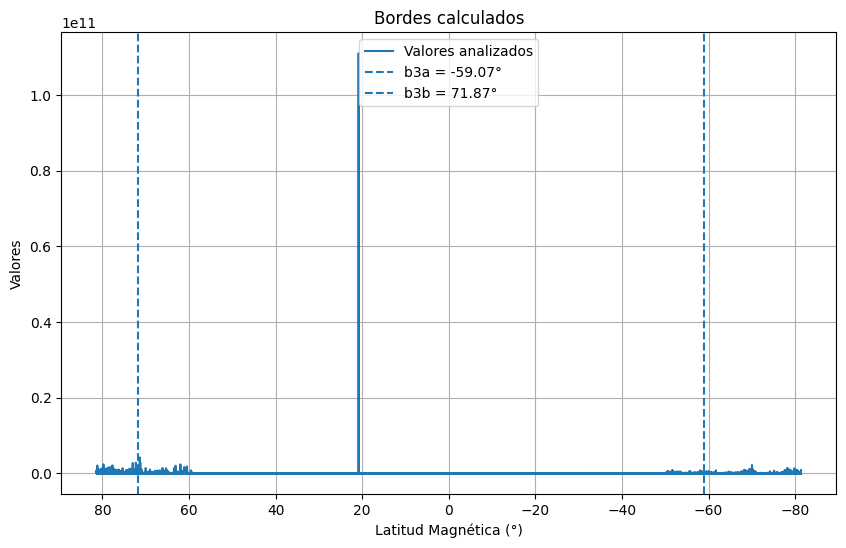

Latitud asociada: 20.826871294047184
Valores del flujo: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.17831539e+09 1.11099535e+11 8.82209500e+06 9.10797920e+07
 2.64279286e+10 3.11347300e+07 7.50905426e+10]


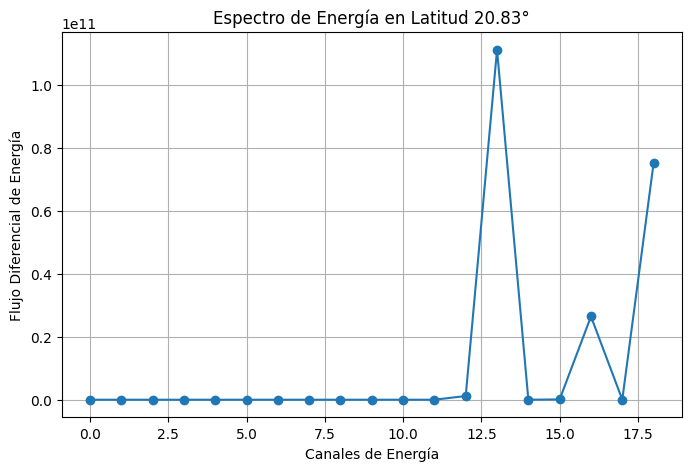

In [7]:
def detectar_pico_monoenergetico(flujo):
    """
    Detecta si un espectro contiene un pico monoenergético.

    Args:
        flujo (array): Flujo diferencial de energía para un espectro dado.

    Returns:
        bool: True si hay un pico monoenergético, False en caso contrario.
    """
    for i in range(1, len(flujo) - 1):
        # Pico al menos 5 veces mayor que otros canales
        if flujo[i] > 5 * max(flujo[:i]) and flujo[i] > 5 * max(flujo[i+1:]):
            return True
        # Caída brusca de al menos un factor de 10
        if flujo[i] > 10 * flujo[i + 1]:
            return True
    return False

def calcular_b3a_b3b(latitudes, flujos):
    """
    Calcula los bordes b3a y b3b como las latitudes más ecuatoriales y polares
    con espectros que contienen picos monoenergéticos.

    Args:
        latitudes (array): Latitudes magnéticas.
        flujos (2D array): Matriz de flujo diferencial de energía (espectros).

    Returns:
        tuple: (latitud b3a, índice b3a, latitud b3b, índice b3b).
    """
    b3a_lat, b3a_ind = None, None
    b3b_lat, b3b_ind = None, None

    for i in range(len(flujos)):
        if detectar_pico_monoenergetico(flujos[i]):
            if b3a_lat is None:
                b3a_lat, b3a_ind = latitudes[i], i
            b3b_lat, b3b_ind = latitudes[i], i

    return b3a_lat, b3a_ind, b3b_lat, b3b_ind

def graficar_bordes(latitudes, valores, bordes):
    """
    Genera un gráfico mostrando los valores y los bordes calculados.

    Args:
        latitudes (array): Latitudes magnéticas.
        valores (array): Valores analizados.
        bordes (list): Lista de tuplas (latitud, índice) de los bordes calculados.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(latitudes, valores, label='Valores analizados')
    for borde, nombre in bordes:
        if borde is not None:
            plt.axvline(borde, linestyle='--', label=f'{nombre} = {borde:.2f}°')
    plt.gca().invert_xaxis()
    plt.xlabel('Latitud Magnética (°)')
    plt.ylabel('Valores')
    plt.title('Bordes calculados')
    plt.legend()
    plt.grid()
    plt.show()

# Cargar el archivo CDF
ruta_archivo = 'dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf'
cdf = cdflib.CDF(ruta_archivo)

# Extraer las variables necesarias
latitudes = cdf.varget('SC_GEOCENTRIC_LAT')
flujos = cdf.varget('ELE_DIFF_ENERGY_FLUX')

# Filtrar valores no válidos (según VALIDMIN y VALIDMAX)
latitudes = np.array(latitudes)
flujos = np.array(flujos)
valid_min = cdf.varattsget('ELE_DIFF_ENERGY_FLUX')['VALIDMIN']
valid_max = cdf.varattsget('ELE_DIFF_ENERGY_FLUX')['VALIDMAX']
fill_value = cdf.varattsget('ELE_DIFF_ENERGY_FLUX')['FILLVAL']

# Reemplazar valores fuera de rango y de relleno por NaN
flujos = np.where((flujos >= valid_min) & (flujos <= valid_max), flujos, np.nan)
flujos[flujos == fill_value] = np.nan

# Eliminar valores NaN
mask = ~np.isnan(flujos).any(axis=1)
latitudes = latitudes[mask]
flujos = flujos[mask]

# Calcular los bordes b3a y b3b
b3a_lat, b3a_ind, b3b_lat, b3b_ind = calcular_b3a_b3b(latitudes, flujos)

if b3a_lat is not None:
    print(f"El borde b3a se encuentra en la latitud magnética: {b3a_lat:.2f}°")
else:
    print("No se encontró el borde b3a en los datos proporcionados.")

if b3b_lat is not None:
    print(f"El borde b3b se encuentra en la latitud magnética: {b3b_lat:.2f}°")
else:
    print("No se encontró el borde b3b en los datos proporcionados.")

# Graficar los resultados
graficar_bordes(latitudes, np.nanmax(flujos, axis=1), [(b3a_lat, 'b3a'), (b3b_lat, 'b3b')])


valores_maximos = np.nanmax(flujos, axis=1)
indice_anomalo = np.argmax(valores_maximos)
print(f"Latitud asociada: {latitudes[indice_anomalo]}")
print(f"Valores del flujo: {flujos[indice_anomalo]}")


plt.figure(figsize=(8, 5))
plt.plot(flujos[indice_anomalo], marker='o')
plt.xlabel('Canales de Energía')
plt.ylabel('Flujo Diferencial de Energía')
plt.title(f'Espectro de Energía en Latitud {latitudes[indice_anomalo]:.2f}°')
plt.grid()
plt.show()



c:\Users\benja\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\benja\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


El borde b4s se encuentra en la latitud magnética: -60.24°


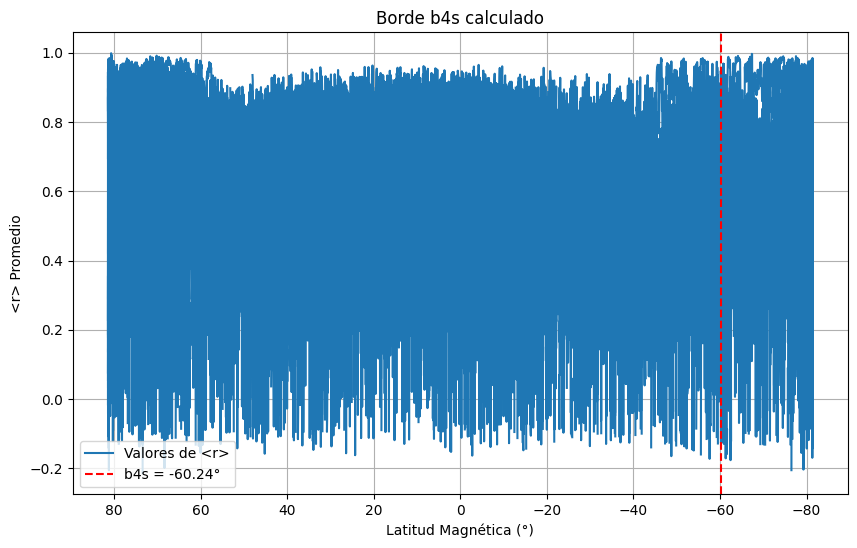

In [9]:
import cdflib
import numpy as np
import matplotlib.pyplot as plt

def calcular_r_promedio(espectro_actual, espectros_anteriores):
    """
    Calcula el coeficiente de correlación promedio <r> entre un espectro actual
    y los cinco espectros anteriores.

    Args:
        espectro_actual (array): Espectro actual.
        espectros_anteriores (2D array): Matriz de los cinco espectros anteriores.

    Returns:
        float: Coeficiente de correlación promedio <r>.
    """
    correlaciones = []
    for espectro in espectros_anteriores:
        correlacion = np.corrcoef(espectro_actual, espectro)[0, 1]
        correlaciones.append(correlacion)
    return np.mean(correlaciones)

def calcular_b4s(latitudes, flujos):
    """
    Calcula el borde b4s basándose en el criterio de correlación promedio.

    Args:
        latitudes (array): Latitudes magnéticas.
        flujos (2D array): Matriz de flujo diferencial de energía (espectros).

    Returns:
        tuple: (latitud b4s, índice b4s).
    """
    n_espectros = len(flujos)
    r_promedios = []

    # Calcular <r> para cada espectro a partir del sexto (5 anteriores necesarios)
    for i in range(5, n_espectros):
        r_promedio = calcular_r_promedio(flujos[i], flujos[i-5:i])
        r_promedios.append(r_promedio)

    # Condición de detención y selección de b4s
    for i in range(len(r_promedios) - 6):
        if np.mean(r_promedios[i:i+7]) < 4.0:
            for j in range(i+6, i-1, -1):
                if r_promedios[j] > 0.60:
                    return latitudes[j + 5], j + 5  # Ajuste por el offset inicial

    return None, None

def graficar_b4s(latitudes, r_promedios, b4s):
    """
    Genera un gráfico mostrando los valores de <r> y el borde b4s calculado.

    Args:
        latitudes (array): Latitudes magnéticas.
        r_promedios (array): Valores de <r> calculados.
        b4s (tuple): Latitud e índice del borde b4s.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(latitudes[5:], r_promedios, label='Valores de <r>')
    if b4s[0] is not None:
        plt.axvline(b4s[0], linestyle='--', color='red', label=f'b4s = {b4s[0]:.2f}°')
    plt.gca().invert_xaxis()
    plt.xlabel('Latitud Magnética (°)')
    plt.ylabel('<r> Promedio')
    plt.title('Borde b4s calculado')
    plt.legend()
    plt.grid()
    plt.show()

# Cargar el archivo CDF
ruta_archivo = 'dmsp-f16_ssjs_precipitating-electrons-ions_20130531000000_20130531230000_cdaweb.cdf'
cdf = cdflib.CDF(ruta_archivo)

# Extraer las variables necesarias
latitudes = cdf.varget('SC_GEOCENTRIC_LAT')
flujos = cdf.varget('ELE_DIFF_ENERGY_FLUX')

# Filtrar valores no válidos (según VALIDMIN y VALIDMAX)
latitudes = np.array(latitudes)
flujos = np.array(flujos)
valid_min = cdf.varattsget('ELE_DIFF_ENERGY_FLUX')['VALIDMIN']
valid_max = cdf.varattsget('ELE_DIFF_ENERGY_FLUX')['VALIDMAX']
fill_value = cdf.varattsget('ELE_DIFF_ENERGY_FLUX')['FILLVAL']

# Reemplazar valores fuera de rango y de relleno por NaN
flujos = np.where((flujos >= valid_min) & (flujos <= valid_max), flujos, np.nan)
flujos[flujos == fill_value] = np.nan

# Eliminar valores NaN
mask = ~np.isnan(flujos).any(axis=1)
latitudes = latitudes[mask]
flujos = flujos[mask]

# Calcular el borde b4s
b4s_lat, b4s_ind = calcular_b4s(latitudes, flujos)

if b4s_lat is not None:
    print(f"El borde b4s se encuentra en la latitud magnética: {b4s_lat:.2f}°")
else:
    print("No se encontró el borde b4s en los datos proporcionados.")

# Calcular <r> para graficar
r_promedios = [calcular_r_promedio(flujos[i], flujos[i-5:i]) for i in range(5, len(flujos))]

# Graficar los resultados
graficar_b4s(latitudes, r_promedios, (b4s_lat, b4s_ind))


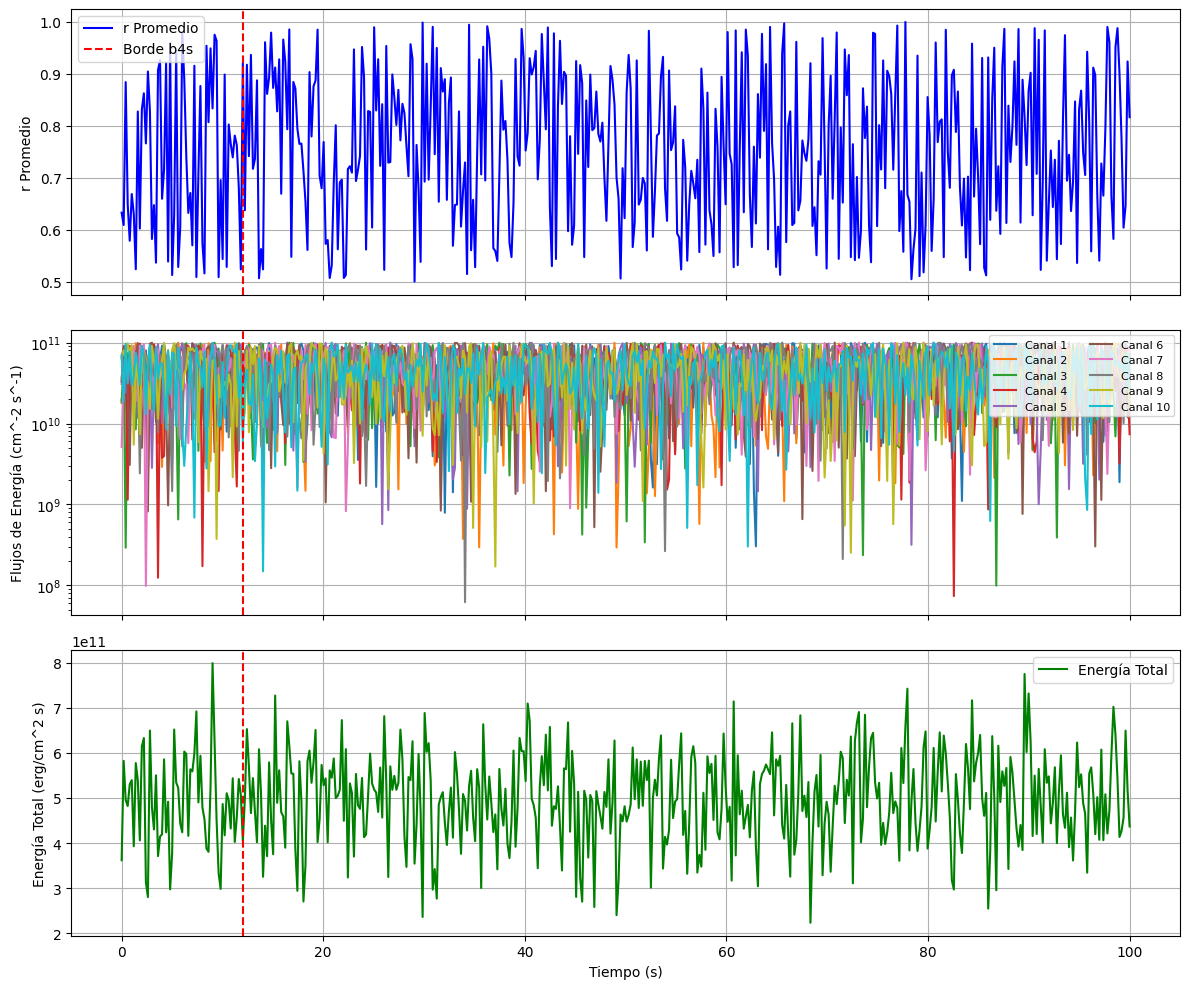

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Datos simulados (puedes reemplazar estos con tus datos reales)
tiempo = np.linspace(0, 100, 500)  # Tiempo simulado (segundos)
r_promedio = np.random.uniform(0.5, 1.0, len(tiempo))  # Correlaciones simuladas
flujos = np.random.uniform(1e7, 1e11, (len(tiempo), 10))  # Flujos simulados (10 canales)
energia_total = np.sum(flujos, axis=1)  # Energía total precipitada simulada

# Detectar bordes (puedes usar tus algoritmos de detección aquí)
borde_b4s = 60  # Índice arbitrario como ejemplo

# Crear los subgráficos
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Primer panel: Correlaciones promedio (r)
axs[0].plot(tiempo, r_promedio, label="r Promedio", color="blue")
axs[0].axvline(tiempo[borde_b4s], color="red", linestyle="--", label="Borde b4s")
axs[0].set_ylabel("r Promedio")
axs[0].legend()
axs[0].grid(True)

# Segundo panel: Flujos de energía diferencial
for canal in range(flujos.shape[1]):
    axs[1].plot(tiempo, flujos[:, canal], label=f"Canal {canal + 1}")
axs[1].axvline(tiempo[borde_b4s], color="red", linestyle="--")
axs[1].set_ylabel("Flujos de Energía (cm^-2 s^-1)")
axs[1].set_yscale("log")
axs[1].grid(True)
axs[1].legend(ncol=2, fontsize=8, loc="upper right")

# Tercer panel: Energía total precipitada
axs[2].plot(tiempo, energia_total, label="Energía Total", color="green")
axs[2].axvline(tiempo[borde_b4s], color="red", linestyle="--")
axs[2].set_ylabel("Energía Total (erg/cm^2 s)")
axs[2].set_xlabel("Tiempo (s)")
axs[2].grid(True)
axs[2].legend()

# Ajustar espacio entre subgráficos
plt.tight_layout()
plt.show()
